Predict a new venue's popularity from information available when the venue opens

In [3]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In [4]:
#create a list of ratings
star_ratings = [row['stars'] for row in data]
star_ratings[:3]

[3.5, 4.0, 4.0]

We wish to build an estimator to make a prediction based on different cities, but first we need to work out the average rating for each city. Create a list of tuples (city name, star rating), one for each city in the data set. 

In [7]:
from collections import defaultdict

star_sum = defaultdict(int)
count = defaultdict(int)

for row in data:
    city = row["city"]
    stars = row["stars"]
    star_sum[city] += stars
    count[city] += 1
    
avg_stars = {city: star_sum[city]/ count[city] for city in star_sum}

for city, stars in avg_stars.items():
    print(f"City:{city}, Stars: {stars:.2f}")

City:Phoenix, Stars: 3.67
City:De Forest, Stars: 3.75
City:Mc Farland, Stars: 3.10
City:Middleton, Stars: 3.61
City:Madison, Stars: 3.65
City:Sun Prairie, Stars: 3.46
City:Windsor, Stars: 3.50
City:Monona, Stars: 3.47
City:Chandler, Stars: 3.67
City:Scottsdale, Stars: 3.82
City:Tempe, Stars: 3.64
City:Florence, Stars: 3.62
City:Peoria, Stars: 3.64
City:Glendale, Stars: 3.61
City:Cave Creek, Stars: 3.91
City:Paradise Valley, Stars: 3.67
City:Mesa, Stars: 3.59
City:Ahwatukee, Stars: 3.69
City:Pheonix, Stars: 3.00
City:Anthem, Stars: 3.78
City:Gilbert, Stars: 3.75
City:Gold Canyon, Stars: 3.50
City:Apache Junction, Stars: 3.64
City:Goldfield, Stars: 3.50
City:Casa Grande, Stars: 3.52
City:Coolidge, Stars: 3.44
City:Higley, Stars: 3.50
City:Queen Creek, Stars: 3.65
City:Sun Lakes, Stars: 3.22
City:Goodyear, Stars: 3.53
City:Fort Mcdowell, Stars: 4.00
City:Fountain Hills, Stars: 3.79
City:Fountain Hls, Stars: 3.00
City:Maricopa, Stars: 3.52
City:chandler, Stars: 5.00
City:Buckeye, Stars: 3.

In [8]:
avg_stars.items()

dict_items([('Phoenix', 3.6702903946388683), ('De Forest', 3.75), ('Mc Farland', 3.1), ('Middleton', 3.611111111111111), ('Madison', 3.6457337883959045), ('Sun Prairie', 3.455223880597015), ('Windsor', 3.5), ('Monona', 3.4727272727272727), ('Chandler', 3.667574931880109), ('Scottsdale', 3.8206757594544327), ('Tempe', 3.644621295279912), ('Florence', 3.6176470588235294), ('Peoria', 3.6388367729831144), ('Glendale', 3.607404021937843), ('Cave Creek', 3.9122137404580153), ('Paradise Valley', 3.6690140845070425), ('Mesa', 3.5901461829994585), ('Ahwatukee', 3.6875), ('Pheonix', 3.0), ('Anthem', 3.7818181818181817), ('Gilbert', 3.752396166134185), ('Gold Canyon', 3.5), ('Apache Junction', 3.6375), ('Goldfield', 3.5), ('Casa Grande', 3.5172413793103448), ('Coolidge', 3.4375), ('Higley', 3.5), ('Queen Creek', 3.6456043956043955), ('Sun Lakes', 3.2222222222222223), ('Goodyear', 3.5313653136531364), ('Fort Mcdowell', 4.0), ('Fountain Hills', 3.7904761904761903), ('Fountain Hls', 3.0), ('Maricopa

city_model: build a custom estimator that will make a prediction based solely on the city of a venue.

In [24]:
from collections import defaultdict
from sklearn.base import BaseEstimator, RegressorMixin

#put previous calculation of rating/city in a class
class CityRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.star_sum = defaultdict(int)
        self.count = defaultdict(int)
        self.avg_stars = dict()
    
    def fit(self, X, y):
        # Store the average rating per city in self.avg_stars
        for row in X:
            city = row["city"]
            stars = row["stars"]
            self.star_sum[city] += stars
            self.count[city] += 1
        self.avg_stars = {city: self.star_sum[city]/ self.count[city] for city in self.star_sum}
        return self
    
    def predict(self, X):
        avg_ratings = [self.avg_stars.get(row["city"], 0) for row in X]
        return avg_ratings
    
city_model = CityRegressor()
city_model.fit(data, star_ratings)

CityRegressor()

In [10]:
city_model.predict(data[:4])

[3.6702903946388683, 3.75, 3.75, 3.75]

In [11]:
city_model.predict([{'city': 'Phoenix'}, {'city': 'Timbuktu'}, {'city': 'Madison'}])

[3.6702903946388683, 0, 3.6457337883959045]

lat_long_model: Use the latitude and longitude of a venue as features that help you understand neighborhood dynamics.

In [13]:
import pandas as pd
from sklearn.base import TransformerMixin

#convert dict to df
class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return a pandas data frame from X
        X = pd.DataFrame.from_dict(X)
        return X

to_data_frame = ToDataFrame()
X_t = to_data_frame.fit_transform(data[:5])
(X_t == pd.DataFrame(data[:5])).all(axis=None)

True

In [15]:
import numpy as np
from sklearn.compose import ColumnTransformer

selector = ColumnTransformer(
    transformers=[('latutide', to_data_frame, ['latitude']), ('longitude', to_data_frame, ['longitude'])
])

expected = np.array([data[0]['latitude'], data[0]['longitude']])
(selector.fit_transform(X_t)[0] == expected).all()

True

In [17]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('todataframe', to_data_frame),
    ('select', selector),
    ('knn', knn)
    
])

pipe.fit(data, star_ratings)
pipe.predict(data[:5])

array([3.98333333, 3.81666667, 3.78333333, 3.6       , 3.83333333])

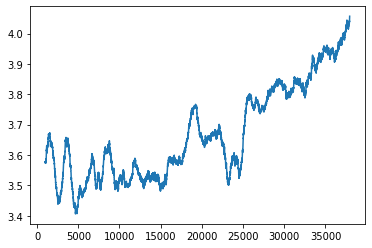

In [18]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean());

In [19]:
# Tune hyperparameter n_neighbors, which tells it how many nearest neighbors to average together when making a prediction.

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, star_ratings, test_size=0.33)

clf = GridSearchCV(KNeighborsRegressor(), {'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
    cv =5, return_train_score= False)


clf.fit(data_transform, star_ratings)
print(clf.cv_results_)
clf.best_params_

{'mean_fit_time': array([0.00863385, 0.00738716, 0.00732059, 0.00731831, 0.0073864 ,
       0.00735502, 0.00739121, 0.0073771 , 0.00738087, 0.00756798,
       0.00734448, 0.00743675, 0.00736375, 0.00740113, 0.00734568,
       0.0073658 , 0.00733643, 0.00734429, 0.00734224, 0.00734982,
       0.00736246, 0.00735102, 0.00732393, 0.00734801, 0.00734963,
       0.00734692, 0.00739117, 0.00744262, 0.00737162, 0.00733714]), 'std_fit_time': array([1.56623306e-03, 9.00317298e-05, 5.45709660e-05, 5.53881613e-05,
       7.51971443e-05, 4.71578208e-05, 9.73212842e-05, 5.70743205e-05,
       1.08577884e-04, 4.56245074e-04, 3.49713815e-05, 1.74069795e-04,
       3.00616994e-05, 1.44182311e-04, 4.60813219e-05, 9.73917688e-05,
       5.64325042e-05, 6.17636479e-05, 4.02145360e-05, 7.11126488e-05,
       5.07999670e-05, 5.43714811e-05, 6.72643674e-05, 5.34775371e-05,
       3.94810225e-05, 5.70454305e-05, 7.43485928e-05, 9.64920491e-05,
       3.87558622e-05, 5.71821800e-05]), 'mean_score_time': array

{'n_neighbors': 30}

In [16]:
# Feed the output of the transformer in to a KNeighborsRegressor

from sklearn.neighbors import KNeighborsRegressor

# Training the model
data_transform = to_data_frame.transform(data)
data_transform = selector.fit_transform(data_transform)
knn = KNeighborsRegressor(n_neighbors=30) #change n_neighbors to 30 after doing the gridreseach
knn.fit(data_transform, star_ratings)

# Making predictions
test_data = data[:5]
test_data_transform = to_data_frame.transform(test_data)
test_data_transform = selector.transform(test_data_transform)
knn.predict(test_data_transform)

array([3.98333333, 3.81666667, 3.78333333, 3.6       , 3.83333333])

In [25]:
lat_long_model = pipe.fit(X_train, y_train)

In [26]:
from sklearn.metrics import mean_absolute_error

y_pred = lat_long_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.7057015441959531


category_model: build an estimator that considers only the categories field of the data, one-hot(or multiple) encoded the categories

In [27]:
#string to dict
def transform_to_dicts(X):
    return pd.Series([{word: 1 for word in list_} for list_ in X])
        
# for testing purpose
X_in1 = pd.Series([['Doctors'], ['Health & Medical']])
X_out1 = transform_to_dicts(X_in1)
print(X_out1)

0             {'Doctors': 1}
1    {'Health & Medical': 1}
dtype: object


In [28]:
#string to dict
class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X will be a pandas series. Return a pandas series of dictionaries
        return pd.Series([{word: 1 for word in list_} for list_ in X])

In [29]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge

dict_encoder = DictEncoder()
dict_vectorizer = DictVectorizer()

# for testing purpose
X_ctg = dict_encoder.fit_transform(X_t['categories'])
#print(X_ctg)

X_onehot = dict_vectorizer.fit_transform(X_ctg)
#print(X_onehot)

ridge = Ridge(alpha = 5)
ridge.fit(X_onehot, star_ratings[:5])

# for testing purpose
print(ridge.predict(X_onehot))
print(star_ratings[:5])
print(ridge.score(X_onehot, star_ratings[:5]))


[3.8125 4.     4.     4.1875 4.    ]
[3.5, 4.0, 4.0, 4.5, 4.0]
0.609375


In [32]:
dict_encoder = DictEncoder()
dict_vectorizer = DictVectorizer()

pipe1 = Pipeline([
    ('dict_encoder', dict_encoder), 
    ('dict_vectorizer', dict_vectorizer)])

ct1 = ColumnTransformer([('one_hot', pipe1, 'categories')])

# for testing purpose
#ct1.fit_transform(pd.DataFrame(data), star_ratings)

pipe2 = Pipeline(
    [('to_data_frame', to_data_frame), 
     ('ct1', ct1), 
     ('ridge', ridge)])

pipe2.fit(data, star_ratings)
pipe2.predict(data[:20])

array([3.35977596, 3.36376454, 3.29169566, 3.22648514, 3.30927342,
       3.46086478, 4.0671917 , 3.92581242, 4.09757893, 3.3143259 ,
       4.05870852, 3.56585037, 3.30049629, 3.30927342, 4.15189567,
       4.05341024, 3.51467447, 4.19129119, 4.24440033, 3.35318938])

In [34]:
gs2 = GridSearchCV(pipe2, {'ridge__alpha': np.logspace(-1.0, 1.0, num=7)})
gs2.fit(X_train, y_train)
print(gs2.best_params_)

{'ridge__alpha': 4.6415888336127775}


In [35]:
category_model = pipe2.set_params(ridge__alpha=4.6415888336127775).fit(X_train, y_train)

In [36]:
y_pred = category_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
# Worse than lat_long_model

Mean Absolute Error: 0.6347757579035643


Attribute_model: build an estimator based on attributes for each venue. Venues attributes may be nested, so need to flatten the dictionary to a single level first.

In [37]:
# Build a custom transformer that flattens the dictionary for the attributes field.

class AttributeTransformer(BaseEstimator, TransformerMixin):
    # Create the transformer to handle the attributes data
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X will be a pandas series. Return a pandas series of dictionaries
        def flatten(input: dict, prefix: str = '') -> dict:
            output = dict()
            
            for key in input:
                if type(input[key]) in {str, int, float}:
                    output[prefix + key + '_' + str(input[key])] = 1
                elif type(input[key]) == bool:
                    output[prefix + key] = int(input[key])
                elif type(input[key]) == list:
                    for item in input[key]:
                        output[prefix + str(item)] = 1
                else:
                    tmp = flatten(input[key], prefix + key + '_')
                    output.update(tmp)
            
            return output
        
        return pd.Series([flatten(attr) for attr in X])

In [38]:
attribute_example = pd.Series([
    {
        'Wi-Fi': 'free',
        'Price Range': 2,
        'Parking': {
            'garage': False,
            'street': True
        }
    },
    {
        'Wi-Fi': 'no',
        'Price Range': 3,
        'Accepts Credit Cards': True,
        'Take-out': False
    },
    {
        'Wi-Fi': 'paid',
        'Parking': {
            'garage': True,
            'valet': True
        },
        'Take-out': True
    }
])

n_columns = 10

test_att_transformer = AttributeTransformer()
dictvect = DictVectorizer()

dictvect.fit(test_att_transformer.fit_transform(attribute_example))

test_att_transformer.fit_transform(attribute_example)
len(dictvect.feature_names_) == n_columns

True

In [39]:
# Create the linear + non-linear ensemble predictor
attr_trans = AttributeTransformer()
dict_vectorizer1 = DictVectorizer()
pipe3 = Pipeline([('attr_trans', attr_trans), ('dict_vectorizer1', dict_vectorizer1)])

# Create the attribute model
ct2 = ColumnTransformer([('one_hot1', pipe3, 'attributes')])
ridge1 = Ridge()
pipe4 = Pipeline([('to_data_frame', to_data_frame), ('ct2', ct2), ('ridge1', ridge1)])
attribute_model = pipe4.fit(data, star_ratings)
pipe4.predict(data)

from sklearn.neighbors import KNeighborsRegressor
class LinearNonlinearPredictor(BaseEstimator, TransformerMixin):
    # Create the transformer to handle the attributes data
    def fit(self, X, y=None):
        import random
        tmp = list(zip(X, y))
        random.shuffle(tmp)
        X, y = zip(*tmp)
        X, y = list(X), list(y)
        
        self.pipe5 = Pipeline([('to_data_frame', to_data_frame), ('ct2', ct2), ('ridge1', ridge1)])
        
        gscv = GridSearchCV(self.pipe5, [{'ridge1__alpha': np.logspace(-3, 3, 7)}])
        gscv.fit(X, y)
        print(gscv.cv_results_)
        print(gscv.best_params_)
        
        #self.pipe5.fit(X, y)
        self.pipe5.set_params(**gscv.best_params_).fit(X, y)
        
        pipe5_pred = self.pipe5.predict(X)
        res = y - pipe5_pred

        #from matplotlib.pyplot import scatter
        #scatter(pipe5_pred, y)
        
        #selector1 = ColumnTransformer(transformers=[('review_count', to_data_frame, 'review_count'),
        #                                            ('state', OneHotEncoder(handle_unknown="ignore"), ['state'])])
        knn = KNeighborsRegressor()
        #self.pipe6 = Pipeline([('to_data_frame', to_data_frame), ('selector1', selector1), ('dec_tree', dec_tree)])
        self.pipe6 = Pipeline([('to_data_frame', to_data_frame), ('ct2', ct2), ('knn', knn)])

        gscv2 = GridSearchCV(self.pipe6, [{'knn__n_neighbors':[50, 80, 100, 120, 150]}])
        gscv2.fit(X, res)
        print(gscv2.cv_results_)
        print(gscv2.best_params_)
        
        #self.pipe6.fit(X, res)
        self.pipe6.set_params(**gscv2.best_params_).fit(X, res)
        
        return self

    def predict(self, X):
        # X will be a pandas series. Return a pandas series of dictionaries
        return self.pipe5.predict(X) + self.pipe6.predict(X)

In [52]:
from sklearn.neighbors import KNeighborsRegressor
class LinearNonlinearPredictor(BaseEstimator, TransformerMixin):
    # Create the transformer to handle the attributes data
    def fit(self, X, y=None):
        import random
        tmp = list(zip(X, y))
        random.shuffle(tmp)
        X, y = zip(*tmp)
        X, y = list(X), list(y)
        
        self.pipe5 = Pipeline([('to_data_frame', to_data_frame), ('ct2', ct2), ('ridge1', ridge1)])
        gscv = GridSearchCV(self.pipe5, [{'ridge1__alpha': np.logspace(-3, 3, 7)}], cv=5)
        gscv.fit(X, y)
        self.pipe5 = gscv.best_estimator_  # Use the best estimator
        
        pipe5_pred = self.pipe5.predict(X)
        res = y - pipe5_pred

        self.pipe6 = Pipeline([('to_data_frame', to_data_frame), ('ct2', ct2), ('knn', KNeighborsRegressor())])
        gscv2 = GridSearchCV(self.pipe6, [{'knn__n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]}], cv=5)
        gscv2.fit(X, res)
        self.pipe6 = gscv2.best_estimator_  # Use the best estimator
        
        return self

    def predict(self, X):
        # X will be a pandas series. Return a pandas series of dictionaries
        return self.pipe5.predict(X) + self.pipe6.predict(X)

In [53]:
lnlt = LinearNonlinearPredictor()
lnlt.fit(data, star_ratings)
lnlt_pred = lnlt.predict(data)
attribute_model = lnlt.fit(data, star_ratings)

In [54]:
y_pred = attribute_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.6700550045461798


Build an ensemble regressor that averages together the estimates of the four previous regressors.

In [55]:
# In order to use the existing models as input to a predictor, we will have to turn them into transformers; a predictor can only be in the final step of a pipeline. 
# Build a custom ModelTransformer class that takes a predictor as an argument. 

class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y=0):
        self.model.fit(X,y)
        return self
    
    def transform(self, X):
        transformation = self.model.predict(X)  
        transformation = np.array(transformation).reshape(-1,1)
    
        return transformation
        
city_model = CityRegressor()
lat_long_model = Pipeline([
    ('todataframe', to_data_frame),
    ('select', selector),
    ('knn', knn)])

category_model = Pipeline([
    ('to_data_frame', to_data_frame), 
    ('ct1', ct1), 
    ('ridge', ridge)])

attribute_model = Pipeline([
    ('to_data_frame', to_data_frame), 
    ('ct2', ct2), 
    ('ridge1', ridge1)])


In [56]:
city_trans = ModelTransformer(city_model)
city_trans.fit(data, star_ratings)
X_t = city_trans.transform(data[:5])

# Check that the transformation output is a 2-D array with one column
np.array(X_t).shape[-1] == 1

True

In [57]:
# Create an instance of ModelTransformer for each of the previous four models. 
# Combine these together in a single feature matrix with a FeatureUnion.

from sklearn.pipeline import FeatureUnion

city_trans = ModelTransformer(city_model)
lat_long_trans = ModelTransformer(lat_long_model)
category_trans = ModelTransformer(category_model)
attribute_trans = ModelTransformer(attribute_model)

union = FeatureUnion([
        # FeatureUnion uses the same syntax as Pipeline
        ("city", city_trans),
        ("lat_long", lat_long_trans),
        ("cat", category_trans),
        ("att", attribute_trans)
    ])


In [47]:
# Our FeatureUnion object should return a feature matrix with four columns.
union.fit(data, star_ratings)
X_t = union.transform(data[:5])

# Transformed data should have 5 rows and 4 columns
X_t.shape == (5, 4)

True

In [58]:
# Finally, use a pipeline to combine the feature union with a linear regression to weight the predictions.

from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
    ('features', union),
    ('regressor', LinearRegression())  # Can use another model instead of Linear Regression
])
pipeline.fit(data, star_ratings)

# Predict using the pipeline
predictions = pipeline.predict(data)
print(predictions)

[3.74261008 3.46280304 3.45121838 ... 4.73774691 3.9125424  4.01036951]


In [59]:
full_model = pipeline.fit(data, star_ratings)

In [60]:
y_pred = full_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.6031621692139899
